# Canonicar DS

## Imports

In [21]:
%%capture
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%pip install ipython-autotime
%load_ext autotime

time: 1.5 s (started: 2025-03-09 14:51:16 +02:00)


## Device Configuration

In [22]:
# scikit-learn regression don't use GPU, may be good for other stuff
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

time: 0 ns (started: 2025-03-09 14:51:18 +02:00)


## Data Collection & Preprocessing

In [23]:
file_path = "vehicle_big_dataset.csv" # Change after having real data
df = pd.read_csv(file_path)
df_subset = df.sample(n=50000, random_state=42) if len(df) > 50000 else df.copy()

time: 4.19 s (started: 2025-03-09 14:51:18 +02:00)


In [24]:
df_subset.head()

,track_id,track_difficulty,vehicle_type,run_id,timestamp,imu_accel_x,imu_accel_y,imu_accel_z,imu_angular_vel_x,imu_angular_vel_y,...,brake,steering,fuel_consumed_liters,engine_rpm,road_surface_friction,weather_condition,air_temperature,collision_detected,collision_force,track_completion_time
104241,4,Hard,Sedan,104241,09-03-25 14:57,0.399171,2.936772,-1.855301,0.414226,-0.464592,...,0.652303,-0.722831,4.538709,970.460394,0.944889,Fog,28.051243,0,1528.268858,158.743291
199676,2,Easy,SUV,199676,10-03-25 17:27,-2.297361,0.601273,0.577410,-0.843869,0.740792,...,0.365779,0.015485,4.906379,1274.923583,0.712541,Rain,10.645722,0,4823.795655,65.289026
140199,4,Hard,Sedan,140199,10-03-25 00:56,1.555085,-0.039491,2.490884,0.468701,0.730131,...,0.986717,-0.013666,0.212964,1444.020847,0.873779,Fog,20.857557,0,2591.868740,248.334806
132814,4,Medium,Sedan,132814,09-03-25 22:53,-1.729239,-2.702859,1.817712,-0.755441,-0.164519,...,0.566859,0.648828,4.404249,2524.523155,0.919642,Clear,19.340309,1,2401.584513,211.325642
408697,3,Medium,SUV,408697,13-03-25 03:31,2.524185,1.302629,-2.493533,-0.148341,0.089861,...,0.480011,0.754721,1.376742,3854.685622,0.654712,Fog,22.091265,0,1269.144407,180.052742


time: 62 ms (started: 2025-03-09 14:51:22 +02:00)


## Predictive Modeling (Regression)

In [25]:
# Make a copy of the dataset for optimization
df_subset_optimized = df_subset.copy()

time: 0 ns (started: 2025-03-09 14:51:22 +02:00)


In [26]:
# Convert categorical columns
categorical_cols = ["track_difficulty", "vehicle_type", "weather_condition"]
for col in categorical_cols:
    if col in df_subset_optimized.columns:
        df_subset_optimized[col] = df_subset_optimized[col].astype("category")

time: 31 ms (started: 2025-03-09 14:51:22 +02:00)


In [27]:
# Drop timestamp column (not needed for regression)
if "timestamp" in df_subset_optimized.columns:
    df_subset_optimized.drop(columns=["timestamp"], inplace=True)

time: 0 ns (started: 2025-03-09 14:51:22 +02:00)


In [28]:
# Convert float64 to float32
float_cols = df_subset_optimized.select_dtypes(include=["float64"]).columns
df_subset_optimized[float_cols] = df_subset_optimized[float_cols].astype("float32")

# Convert int64 to int32
int_cols = df_subset_optimized.select_dtypes(include=["int64"]).columns
df_subset_optimized[int_cols] = df_subset_optimized[int_cols].astype("int32")

time: 31 ms (started: 2025-03-09 14:51:22 +02:00)


In [29]:
df_subset_optimized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 104241 to 265640
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   track_id               50000 non-null  int32   
 1   track_difficulty       50000 non-null  category
 2   vehicle_type           50000 non-null  category
 3   run_id                 50000 non-null  int32   
 4   imu_accel_x            50000 non-null  float32 
 5   imu_accel_y            50000 non-null  float32 
 6   imu_accel_z            50000 non-null  float32 
 7   imu_angular_vel_x      50000 non-null  float32 
 8   imu_angular_vel_y      50000 non-null  float32 
 9   imu_angular_vel_z      50000 non-null  float32 
 10  latitude               50000 non-null  float32 
 11  longitude              50000 non-null  float32 
 12  altitude               50000 non-null  float32 
 13  velocity_kph           50000 non-null  float32 
 14  mass_kg                50000 non-null

In [30]:
df_subset_optimized.head()

,track_id,track_difficulty,vehicle_type,run_id,imu_accel_x,imu_accel_y,imu_accel_z,imu_angular_vel_x,imu_angular_vel_y,imu_angular_vel_z,...,brake,steering,fuel_consumed_liters,engine_rpm,road_surface_friction,weather_condition,air_temperature,collision_detected,collision_force,track_completion_time
104241,4,Hard,Sedan,104241,0.399171,2.936772,-1.855301,0.414226,-0.464592,-0.059118,...,0.652303,-0.722831,4.538709,970.460388,0.944889,Fog,28.051243,0,1528.268799,158.743286
199676,2,Easy,SUV,199676,-2.297361,0.601273,0.577410,-0.843869,0.740792,-0.534714,...,0.365779,0.015485,4.906379,1274.923584,0.712541,Rain,10.645722,0,4823.795898,65.289024
140199,4,Hard,Sedan,140199,1.555085,-0.039491,2.490884,0.468701,0.730131,0.299181,...,0.986717,-0.013666,0.212964,1444.020874,0.873779,Fog,20.857557,0,2591.868652,248.334808
132814,4,Medium,Sedan,132814,-1.729239,-2.702858,1.817712,-0.755441,-0.164519,-0.597793,...,0.566859,0.648827,4.404249,2524.523193,0.919642,Clear,19.340309,1,2401.584473,211.325638
408697,3,Medium,SUV,408697,2.524185,1.302629,-2.493533,-0.148341,0.089861,0.443956,...,0.480011,0.754721,1.376742,3854.685547,0.654712,Fog,22.091265,0,1269.144409,180.052734


time: 31 ms (started: 2025-03-09 14:51:22 +02:00)


In [31]:
selected_features = [
    "velocity_kph", "engine_rpm", "road_surface_friction",
    "imu_accel_x", "imu_accel_y", "imu_accel_z",
    "brake", "throttle", "steering", "mass_kg", "drag_coefficient",
    "collision_detected", "collision_force", "air_temperature"
]

df_clean = df_subset_optimized.dropna(subset=selected_features + ["track_completion_time"])

time: 31 ms (started: 2025-03-09 14:51:22 +02:00)


In [32]:
X = df_clean[selected_features]
y = df_clean["track_completion_time"]

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

Feature Matrix Shape: (50000, 14)
Target Vector Shape: (50000,)
time: 0 ns (started: 2025-03-09 14:51:23 +02:00)


#### Train-test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

time: 16 ms (started: 2025-03-09 14:51:23 +02:00)


In [34]:
# Normalize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 35000 samples
Testing set size: 15000 samples
time: 31 ms (started: 2025-03-09 14:51:23 +02:00)


### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

#### Fit models and compute MSE, RMSE, R² scores

#### Visualize plots

#### Feature importance ranking

### Gaussian Process

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

The model uses a Radial Basis Function (RBF) kernel, which allows it to capture nonlinear relationships.

The ConstantKernel defines the scale of variation.

#### Fit models and compute MSE, RMSE, R² scores

In [98]:
subset_size = 2000
X_train_gpr = X_train_scaled[:subset_size]
y_train_gpr = y_train[:subset_size]

y_scaler = StandardScaler()
y_train_gpr_scaled = y_scaler.fit_transform(y_train_gpr.values.reshape(-1, 1)).ravel()

In [99]:
kernel = DotProduct() + WhiteKernel()

gpr = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=5)

In [100]:
gpr.fit(X_train_gpr, y_train_gpr_scaled)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=5, random_state=42)

In [101]:
# Predict & inverse-transform predictions
y_pred_gpr_scaled, std_dev = gpr.predict(X_test_scaled, return_std=True)
y_pred_gpr = y_scaler.inverse_transform(y_pred_gpr_scaled.reshape(-1, 1)).ravel()

In [102]:
mse_gpr = mean_squared_error(y_test, y_pred_gpr)
r2_gpr = r2_score(y_test, y_pred_gpr)

In [103]:
print(f"Gaussian Process Regression Results:\nMSE: {mse_gpr:.2f}, R² Score: {r2_gpr:.2f}")

Gaussian Process Regression Results:
MSE: 6131.12, R² Score: -0.00


#### Visualize plots

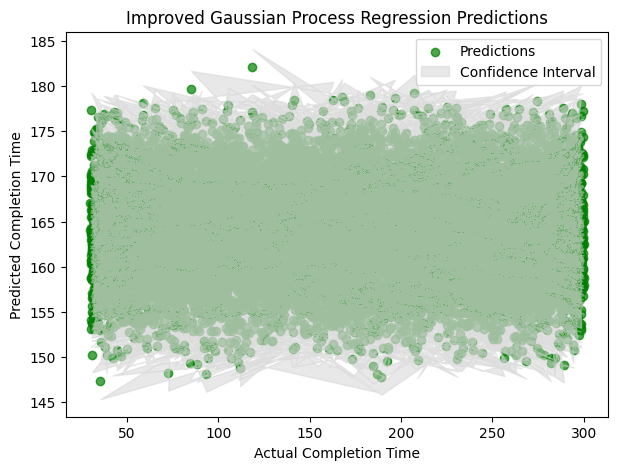

In [104]:
# Plot actual vs predicted values with uncertainty
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_gpr, alpha=0.7, color="green", label="Predictions")
plt.fill_between(y_test, y_pred_gpr - 1.96 * std_dev, y_pred_gpr + 1.96 * std_dev, 
                 color="lightgray", alpha=0.5, label="Confidence Interval")
plt.xlabel("Actual Completion Time")
plt.ylabel("Predicted Completion Time")
plt.title("Improved Gaussian Process Regression Predictions")
plt.legend()
plt.show()


#### Feature importance ranking

### Decision Tree

In [144]:
from sklearn.tree import DecisionTreeRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [177]:
dt_regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)
dt_regressor.fit(X_train_scaled, y_train)
dt_y_pred = dt_regressor.predict(X_test_scaled)

In [ ]:
mse_dt = mean_squared_error(y_test, dt_y_pred)
r2_dt = r2_score(y_test, dt_y_pred)

print(f"Decision Tree Regression Results:\nMSE: {mse_dt:.2f}, R² Score: {r2_dt:.2f}")

Decision Tree Regression Results:
MSE: 6341.95, R² Score: -0.04


#### Visualize plots

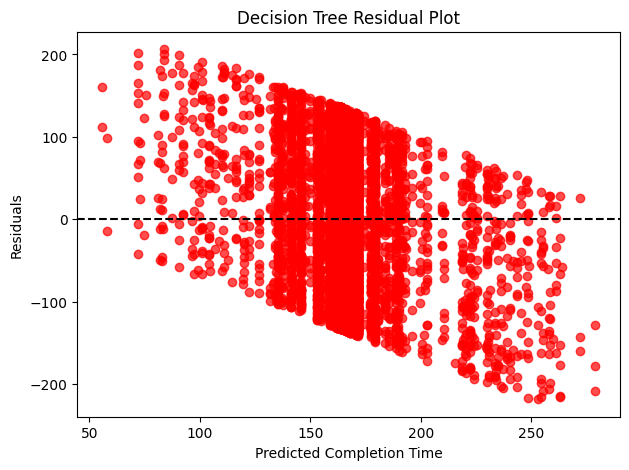

In [ ]:
residuals = y_test - dt_y_pred

plt.figure(figsize=(7,5))
plt.scatter(dt_y_pred, residuals, alpha=0.7, color="red")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted Completion Time")
plt.ylabel("Residuals")
plt.title("Decision Tree Residual Plot")
plt.show()

#### Feature importance ranking

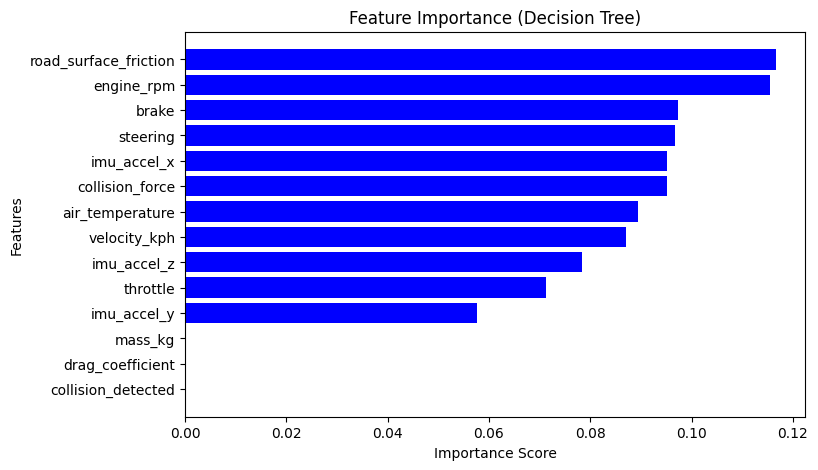

In [ ]:
# Get feature importance scores
feature_importance = dt_regressor.feature_importances_

importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Decision Tree)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


### Random Forest

In [182]:
from sklearn.ensemble import RandomForestRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [183]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train_scaled, y_train)
y_pred_rf = rf_regressor.predict(X_test_scaled)

In [184]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression Results:\nMSE: {mse_rf:.2f}, R² Score: {r2_rf:.2f}")

Random Forest Regression Results:
MSE: 6135.79, R² Score: -0.00


#### Visualize plots

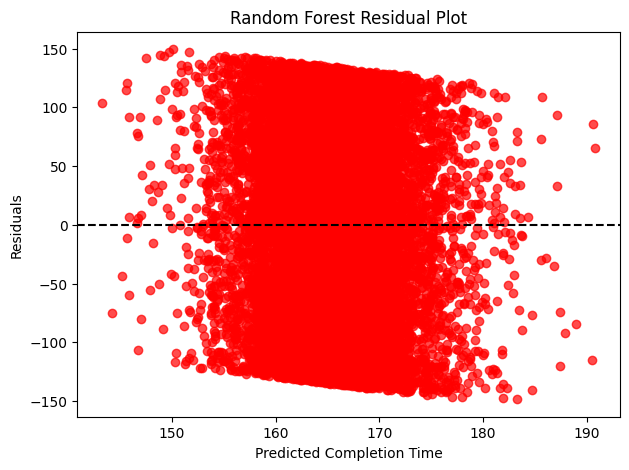

In [185]:
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(7,5))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.7, color="red")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted Completion Time")
plt.ylabel("Residuals")
plt.title("Random Forest Residual Plot")
plt.show()


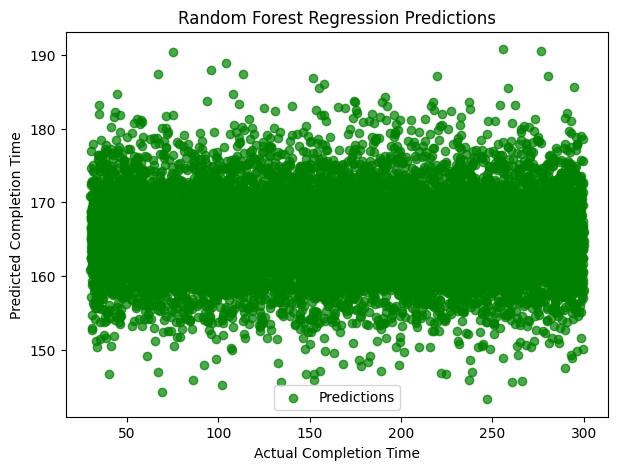

In [186]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color="green", label="Predictions")
plt.xlabel("Actual Completion Time")
plt.ylabel("Predicted Completion Time")
plt.title("Random Forest Regression Predictions")
plt.legend()
plt.show()

#### Feature importance ranking

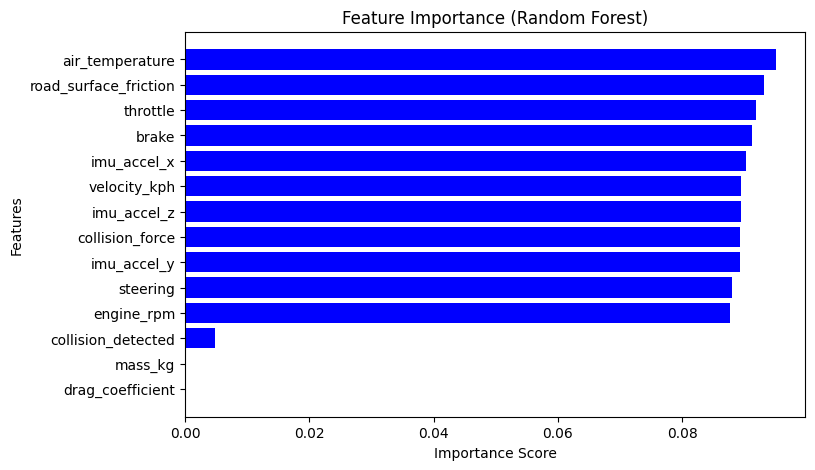

In [187]:
feature_importance_rf = rf_regressor.feature_importances_

importance_df_rf = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance_rf})
importance_df_rf = importance_df_rf.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df_rf["Feature"], importance_df_rf["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


### Gradient Boosting

In [188]:
from sklearn.ensemble import GradientBoostingRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [189]:
gb_regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=10, random_state=42)
gb_regressor.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=200,
                          random_state=42)

In [190]:
y_pred_gb = gb_regressor.predict(X_test_scaled)

In [191]:
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Regression Results:\nMSE: {mse_gb:.2f}, R² Score: {r2_gb:.2f}")

Gradient Boosting Regression Results:
MSE: 6191.37, R² Score: -0.01


#### Visualize plots

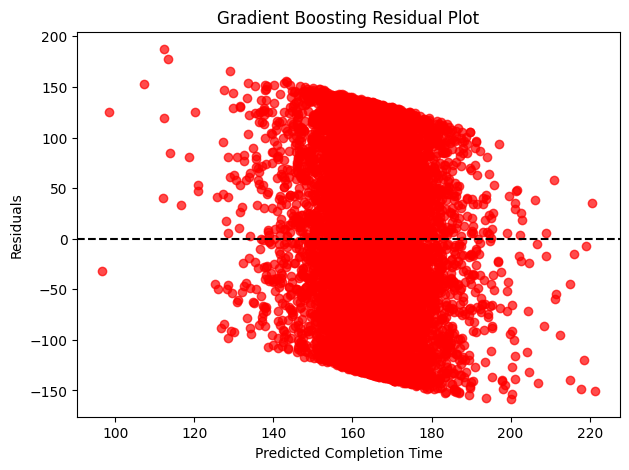

In [192]:
residuals_gb = y_test - y_pred_gb

plt.figure(figsize=(7,5))
plt.scatter(y_pred_gb, residuals_gb, alpha=0.7, color="red")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted Completion Time")
plt.ylabel("Residuals")
plt.title("Gradient Boosting Residual Plot")
plt.show()

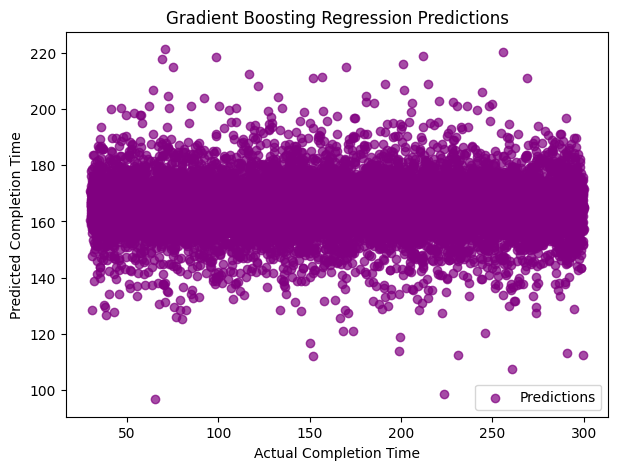

In [193]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_gb, alpha=0.7, color="purple", label="Predictions")
plt.xlabel("Actual Completion Time")
plt.ylabel("Predicted Completion Time")
plt.title("Gradient Boosting Regression Predictions")
plt.legend()
plt.show()


#### Feature importance ranking

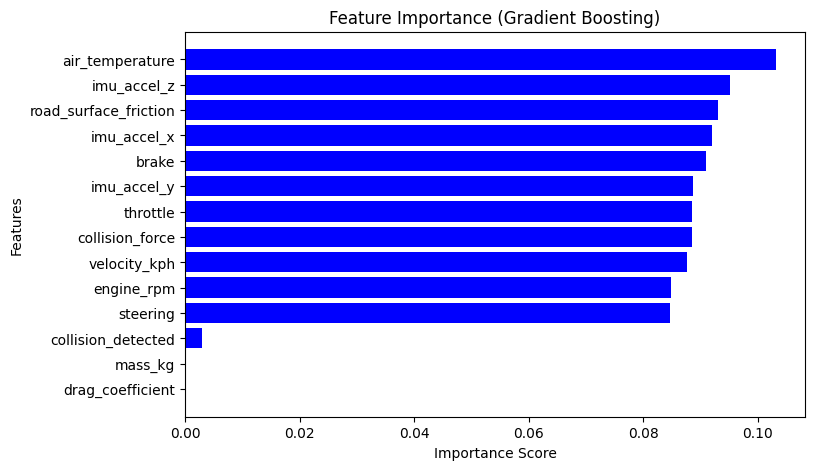

In [194]:
feature_importance_gb = gb_regressor.feature_importances_

importance_df_gb = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance_gb})
importance_df_gb = importance_df_gb.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df_gb["Feature"], importance_df_gb["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Gradient Boosting)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

### Support Vector

In [195]:
from sklearn.svm import SVR

#### Fit models and compute MSE, RMSE, R² scores

In [196]:
svr_regressor = SVR(kernel="rbf", C=1.0, epsilon=0.1)
# Train the model (Can be slow on large datasets)
svr_regressor.fit(X_train_scaled, y_train)
y_pred_svr = svr_regressor.predict(X_test_scaled)

In [197]:
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Support Vector Regression Results:\nMSE: {mse_svr:.2f}, R² Score: {r2_svr:.2f}")

Support Vector Regression Results:
MSE: 6136.58, R² Score: -0.00


#### Visualize plots

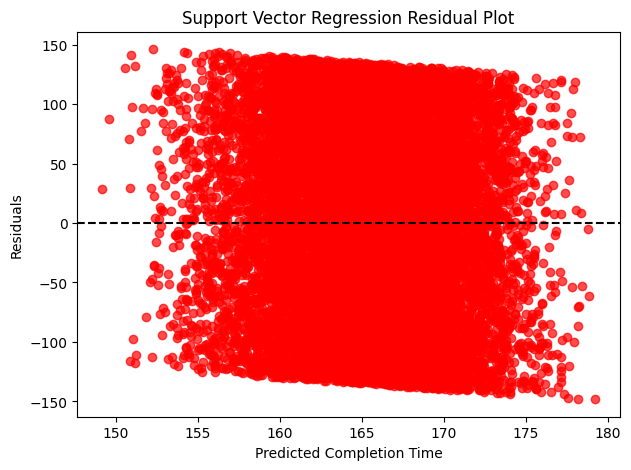

In [198]:
residuals_svr = y_test - y_pred_svr

plt.figure(figsize=(7,5))
plt.scatter(y_pred_svr, residuals_svr, alpha=0.7, color="red")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted Completion Time")
plt.ylabel("Residuals")
plt.title("Support Vector Regression Residual Plot")
plt.show()


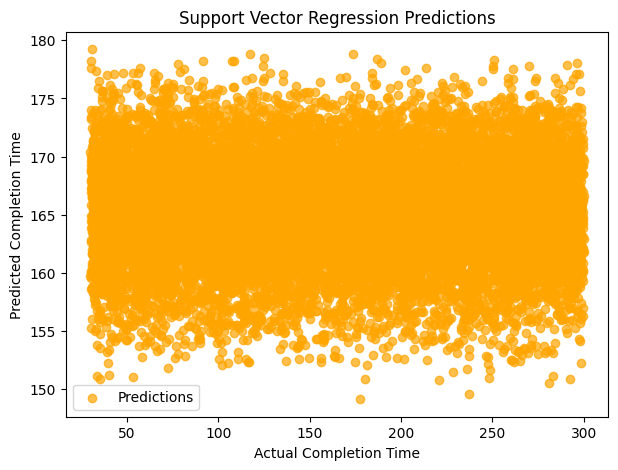

In [199]:
# Plot actual vs. predicted values
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_svr, alpha=0.7, color="orange", label="Predictions")
plt.xlabel("Actual Completion Time")
plt.ylabel("Predicted Completion Time")
plt.title("Support Vector Regression Predictions")
plt.legend()
plt.show()


##  Neural Networks for Regression

#### Train-Validation-Test Split

### Completion Time Prediction
- MLP
- **Activation**: ReLU, Tanh.
- **Loss Function**: MSE.

#### Network

#### Train

#### Test & Evaluate

### Stability Prediction
  - Combination of speed, acceleration, and tire pressure as inputs.
  - Embedding layer for vehicle type (categorical feature).

#### Network

#### Train

#### Test & Evaluate

## Classification - PySpark

### Decision Tree

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### Naive Bayes

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### XGBoost

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### Random Forest

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

## Clustering - PySpark
- Grouping Similar Driving Behaviors

### Evaluation & Visualization

#### Silhouette Score
- To measure clustering quality

#### PCA / t-SNE Plots
- Visualize clusters in 2D/3D